In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests, csv
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.experimental import completer
from shapely.geometry import Point, Polygon

## Data Sources
Census_total_jobs = https://data.census.gov/cedsci/table?q=United%20States&tid=ACSDP5Y2019.DP05

Demand responsive providers = https://docs.google.com/spreadsheets/d/12cu91BcAuqmeFe_Xfie5UJlKClBjbNwFNYeXC8JcM3A/edit#gid=0

### Map Shape Files
Census_tracts = https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
California City Shapefile = https://gisdata-caltrans.opendata.arcgis.com/datasets/4d9f9059e4da4c4e83b7d56f62d0f8aa_0/explore?location=37.368362%2C-122.012770%2C14.36 
California County Shapefile = 

In [2]:
census_total_jobs = pd.read_csv("calitp_acs5_tracts.csv")
transit = pd.read_csv("Demand Response - Geography - Sheet1.csv")

census_tracts = geopandas.read_file('census_tracts/tl_2020_06_tract10.shp')
#city_tracts = geopandas.read_file('california_cities/bx729wr3020.shp')
city_tracts = geopandas.read_file('california_cities/City_Boundaries.shp')

In [3]:
census_tracts.columns = census_tracts.columns.str.replace('GEOID10', 'GEOID')
census_tracts['GEOID'] = census_tracts['GEOID'].astype(int)
census_tracts_data = pd.merge(census_total_jobs, census_tracts, on="GEOID", how = 'inner')
census_tracts_gdf = geopandas.GeoDataFrame(census_tracts_data)

# What is the number of transit services which have demand-responsive transit?

In [4]:
has_demand_responsive = transit.Modes.str.contains("DR",  na = False)
transit['has_demand_responsive'] = has_demand_responsive
transit.has_demand_responsive.value_counts()

True     201
False    199
Name: has_demand_responsive, dtype: int64

## 201 out of 300 have demand responsive

# What is the Percent of California( by area, population, employment) not served by fixed-route transit service?

### What is the percent of california served by fixed-route transit service? 

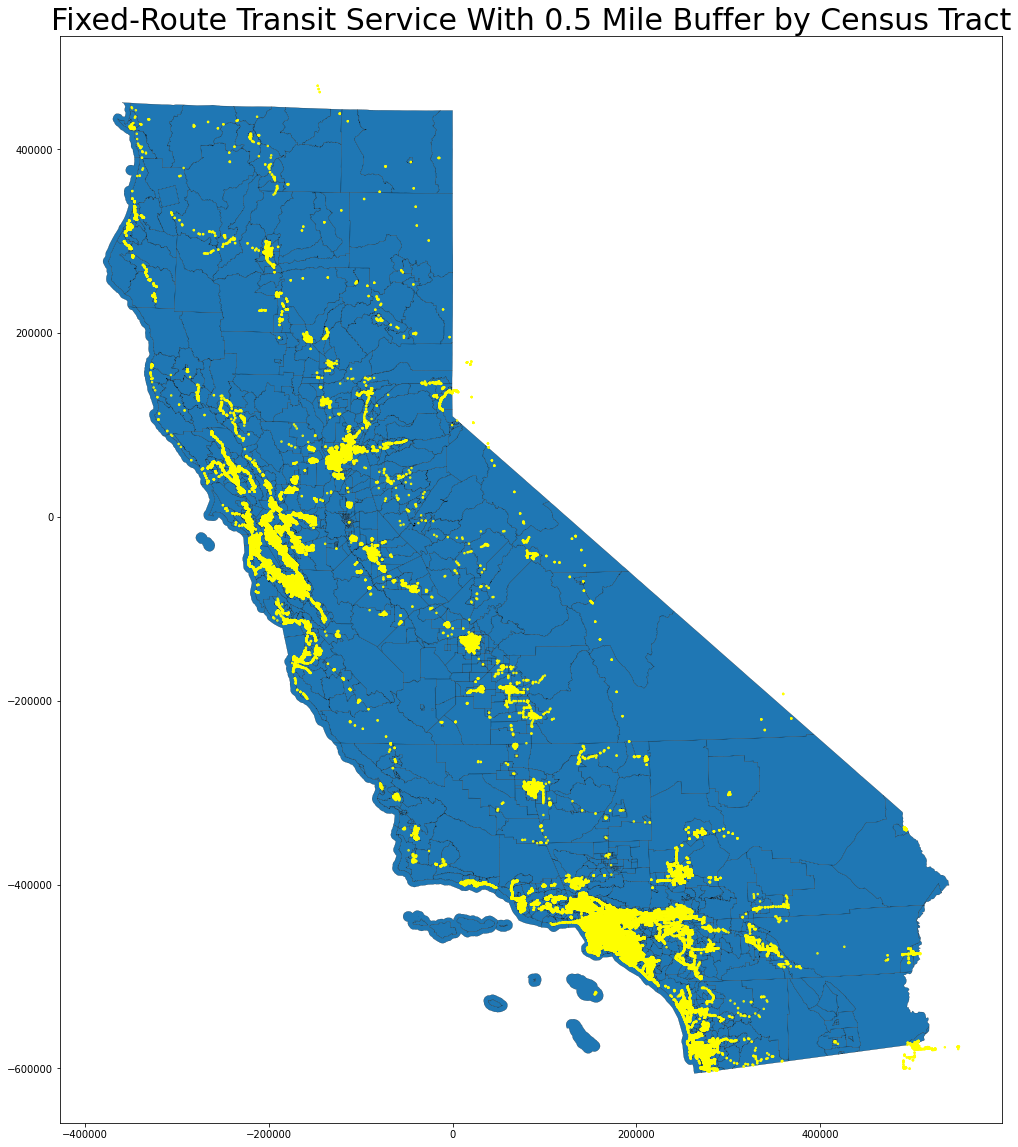

In [12]:
tbl_stop_info = (
    tbl.gtfs_schedule.stops()
    >> filter(_.calitp_itp_id != 284)
    >> select(_,_.stop_lon, _.stop_lat)
    #filter out calitp 284 because have no stop lat/long
    >> collect()
)

#Need to projecy the data to EPSG:3310 California Albers- which is appropriate for displaying and calculating distances in CA 
gdf_stops = geopandas.GeoDataFrame(tbl_stop_info, geometry=geopandas.points_from_xy(tbl_stop_info.stop_lon,tbl_stop_info.stop_lat), crs = "epsg:4326")
gdf_stops_utm = gdf_stops.to_crs(epsg=3310)
census_tracts_utm = census_tracts.to_crs(epsg=3310)

gdf_stops_buffer = gdf_stops_utm.geometry.buffer(805) # conver meters to 0.5 miles 

#plots
ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_buffer.plot(ax=ax, color="none", edgecolor="yellow")
plt.title('Fixed-Route Transit Service With 0.5 Mile Buffer by Census Tract', fontsize = 30)
plt.show()

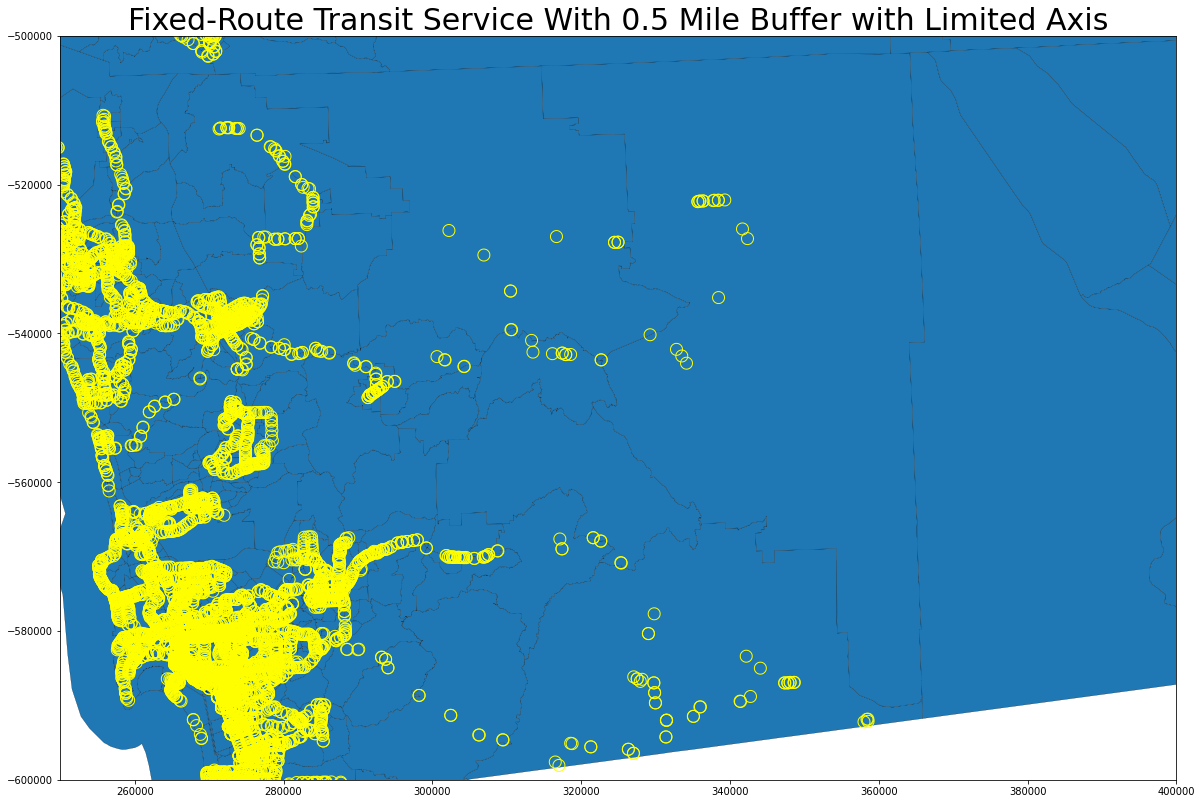

In [6]:
ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_buffer.plot(ax=ax, color="none", edgecolor="yellow")
plt.axis([250000,400000,-600000,-500000])
plt.title('Fixed-Route Transit Service With 0.5 Mile Buffer with Limited Axis', fontsize = 30)
plt.show()

### Calculation of total area via unary_union

Calculates the area of intersection between the buffer and each census tract, divides the intersection area by the census tract area to calculate the fraction of the census tract area contained in the intersection, and then multiplies this decimal number by the census tract population to estimate the number of people who live within the specified distance from the stop. The code also adds all of these calculated geometries and values as columns in a new GeoDataFrame named merged.

In [7]:
#calculation of area by using geopandas unary_method to combine them into a single multipolygon
stops_buffer_union = gdf_stops_buffer.unary_union
census_tracts_union = census_tracts_utm.unary_union
multi_polygon_buffer = stops_buffer_union.area
multi_polygon_total = census_tracts_union.area
print((multi_polygon_buffer/multi_polygon_total)*100)

4.172648541185885


## 4.17% of california is within 0.5 miles of a fixed route transit stop 

#### With the acknowledgement that CALITP may not have data on all fixed route transit stops

## What is the effect of Population and Jobs?

In [15]:
## sandbox

census_tracts_gdf = geopandas.GeoDataFrame(census_tracts_data)
census_tracts_gdf_crs = census_tracts_gdf.to_crs(epsg=3310)

overlap = census_tracts_gdf_crs['geometry'].intersection(stops_buffer_union, align=False)
overlap.name = 'census_overlap'
merged = census_tracts_gdf_crs.join(overlap)
merged['tract_area'] = merged.geometry.area
merged['buffer_area'] = gdf_stops_buffer.area
merged['pct_overlap'] = merged['buffer_area']/merged['tract_area']
merged['affected_pop'] = ((merged['pct_overlap']/100) * merged['ttl_population'])
merged['affected_jobs'] = (merged['pct_overlap']/100) * merged['ttl_jobs']

In [ ]:
#affected population and jobs by census tracts
merged_results = merged[['GEOID','NAME', 'ttl_jobs', 'ttl_population', 'tract_area', 'buffer_area', 'pct_overlap', 'affected_pop', 'affected_jobs']]
merged_results

In [ ]:
# total affected pop and jobs
pct_total_affected_pop = (merged['affected_pop'].sum()/merged['ttl_population'].sum()*100)
pct_total_affected_jobs = (merged['affected_jobs'].sum()/merged['ttl_population'].sum()*100)
print(pct_total_affected_pop, pct_total_affected_jobs)

This calculation assumes the population is evenly distributed across the census tract, which isn’t necessarily true, so the result is only an approximation. At the same time, we’re using census tracts instead of counties for this calculation because, since their geographic areas are smaller, 
the error in this assumption shouldn’t be as great as it would be with counties.

## 1.38% of people and 13.61% of jobs are within 0.5 miles of a fixed route transit stop in california

# What is the percent of California served by demand-responsive transit?

## Of our agencies, which only service demand responsive and no other transit forms?

In [18]:
#Agencies filtered and joined with california transit provider list to get city and county for each agency
dr_transit = pd.read_csv("CalITP Demand Responsive.csv")
dr_transit_overview = pd.read_csv('Primary List of California Transit Providers - Overview.csv')
dr_transit_info = dr_transit_overview[['Transit Provider', 'City', 'County']]

dr_transit_data = pd.merge(dr_transit, dr_transit_info, on="Transit Provider", how = 'inner')

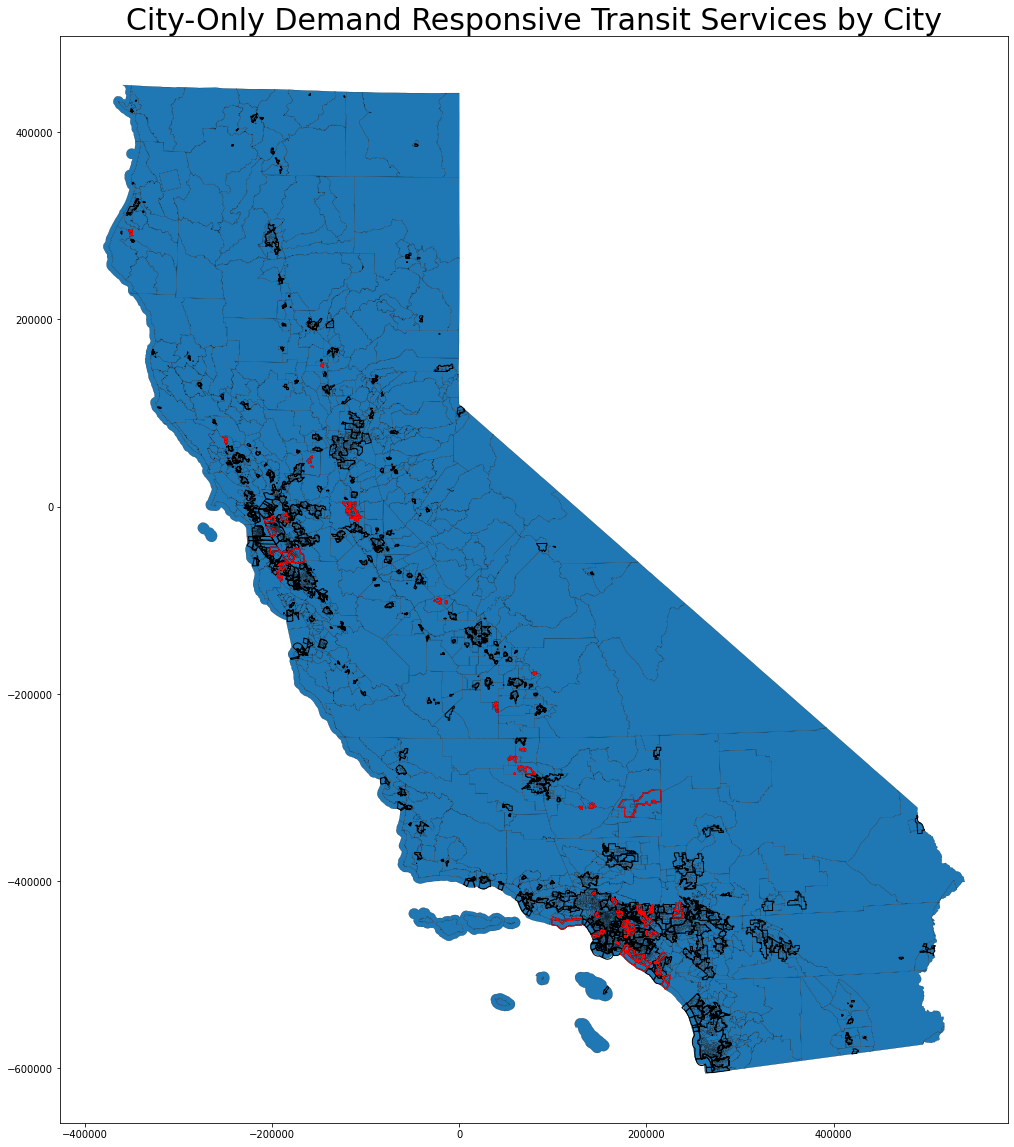

In [19]:
#City only demand responsive 
dr_transit_city = dr_transit_data.loc[dr_transit_data['city only'] == True]
dr_transit_city.columns = dr_transit_city.columns.str.replace('City', 'name')

#all cities in CA
city_tracts.columns = city_tracts.columns.str.replace('NAME', 'name')
ca_city_crs = city_tracts.to_crs(epsg=3310)

#Cities in CA with demand responsive
ca_city_info = pd.merge(ca_city_crs, dr_transit_city, on="name", how = 'inner')
ca_city_info_crs = ca_city_info.to_crs(epsg=3310)


#plot
ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
ca_city_crs.plot(ax=ax, color="none", edgecolor="black")
ca_city_info_crs.plot(ax=ax, color="none", edgecolor="red")
plt.title('City-Only Demand Responsive Transit Services by City', fontsize = 30)
plt.show()

##to-do add legend 


In [24]:
city_area_union = ca_city_info_crs.unary_union
city_tracts_union = ca_city_crs.unary_union
multi_polygon_city = city_area_union.area
multi_polygon_city_total = city_tracts_union.area
demand_transit_city = ((multi_polygon_city/multi_polygon_city_total)*100)
demand_transit_city_total = ((multi_polygon_city/multi_polygon_total)*100)

### 11.34% of cities by area are served by demand response transit, which makes up 0.65% of californias total area

## What is the effect of Population and Jobs?

In [ ]:
## What percent of city-only demand responsive transportation of total
#calculation of area by using geopandas unary_method to combine them into a single multipolygon

gdf_city_buffer = gdf_city_utm.geometry.buffer(805)

gdf_city_union = gdf_city_buffer.unary_union
multi_polygon_city = gdf_city_union.area

df_total_city_buffer = ca_city_utm.geometry.buffer(805)
gdf_total_city_union = df_total_city_buffer.unary_union
multi_polygon_total_city = gdf_total_city_union.area
pct_ca_total = ((multi_polygon_city/multi_polygon_total)*100)

pct_cities_populated = (len(gdf_city_utm)/len(ca_city_utm)) * 100
pct_cities = ((len(gdf_city_utm)/482)*100)
pct_city_total = ((multi_polygon_city/multi_polygon_total_city)*100)
print(pct_cities, pct_city_total)

In [ ]:
#polygon = Polygon(gdf_city_utm['geometry'])
#m = MultiPolygon(polygon)

gdf_city_buffer = gdf_city_utm.geometry.buffer()
multipoly = gdf_city_utm.convex_hull.unary_union
multipoly1 = gdf_city_utm['geometry'].unary_union
multipoly2 = gdf_city_utm['geometry'].unary_union.area

polygon = Polygon(gdf_city_utm['geometry'])
#(gdf_city_utm)
#city_area = multipoly.simplfy
#test = GeoSeries(gdf_city_utm)
#print(gdf_buffer_union[:50])
print(polygon)



## Only 10.37% of california cities and 2.9% of of California cities by area are served by city-only demand responsive transit 

In [ ]:
#use geopandas’ dissolve function to aggregate the data from the census tract level to the county level. 
#We’ll use the sum function to sum the population values for each of the distances from the fault within each county.

In [ ]:

overlap = census_tracts_gdf_crs['geometry'].intersection(gdf_city_union, align=False)
overlap.name = 'census_overlap'
merged = census_tracts_gdf_crs.join(overlap)
merged['tract_area'] = merged.geometry.area
merged['buffer_area'] = gdf_city_buffer.area
merged['pct_overlap'] = merged['buffer_area']/merged['tract_area']
merged['affected_pop'] = ((merged['pct_overlap']/100) * merged['ttl_population'])
merged['affected_jobs'] = (merged['pct_overlap']/100) * merged['ttl_jobs']

merged = census_tracts_gdf_crs.join(overlap)
print(merged)

## Demand responsive county-only

In [ ]:
county_tracts = geopandas.read_file('california_counties/CA_Counties_TIGER2016.shp')
county_tracts.columns = county_tracts.columns.str.replace('NAME', 'County')
dr_transit_county = dr_transit_data.loc[dr_transit_data['county only'] == True]

ca_county_info = pd.merge(dr_transit_county,county_tracts, on="County", how = 'inner')
#convert series to geoseries 
#gdf_county_info = geopandas.GeoDataFrame(ca_county_info, geometry= ca_county_info['geometry'], crs = "epsg:4326")


gdf_county = geopandas.GeoDataFrame(ca_county_info, geometry=geopandas.points_from_xy(ca_county_info.INTPTLON,ca_county_info.INTPTLAT), crs = "epsg:4326")
gdf_county_utm = gdf_county['geometry'].to_crs(epsg=3310)

county_tracts_utm = county_tracts.to_crs(epsg=3310)

ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_county_utm.plot(ax=ax, color="red", edgecolor="black")

county_tracts_utm.plot(ax=ax, color= "none", edgecolor="black")
plt.title('County-only Demand Responsive Transit Services', fontsize = 30)
plt.show()



# What is the total ridership of demand-responsive transit services?

In [ ]:
ntd_stats = pd.read_csv("Primary List of California Transit Providers - NTD Stats.csv")
ntd_stats_df = pd.DataFrame(ntd_stats)
ntd_stats_df['UPT_DR'] = ntd_stats_df['UPT_DR'].str.replace(',', '').astype(float)
total = ntd_stats_df['UPT_DR'].sum()

## Total ridership of demand-responsive transit services for California is 13,305,747 